# Boing boing: Dance Motion Detectionn #

## CNN version 0.1 Date: 2021.9.1 ##

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 13.3 MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Load Dateset #

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/motionsense_dataset'
print(os.listdir(data_path))

['.DS_Store', 'wlk_15', 'dws_2', 'dws_11', 'std_14', 'wlk_7', 'jog_9', 'wlk_8', 'ups_3', 'sit_13', 'ups_12', 'std_6', 'jog_16', 'dws_1', 'ups_4', 'sit_5']


In [ ]:
folders = glob(os.path.join(data_path,'*_*'))
folders = [s for s in folders if ("csv" not in s) or (".DS_Store" not in s) or (".ipynb" not in s)]
df_all_list = []
activity_codes = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}
activity_decodes = {0:'dws',1:'jog',2:'sit',3:'std',4:'ups',5:'wlk'}
activity_types = list(activity_codes.keys())
print(folders)

['/content/drive/MyDrive/motionsense_dataset/wlk_15', '/content/drive/MyDrive/motionsense_dataset/dws_2', '/content/drive/MyDrive/motionsense_dataset/dws_11', '/content/drive/MyDrive/motionsense_dataset/std_14', '/content/drive/MyDrive/motionsense_dataset/wlk_7', '/content/drive/MyDrive/motionsense_dataset/jog_9', '/content/drive/MyDrive/motionsense_dataset/wlk_8', '/content/drive/MyDrive/motionsense_dataset/ups_3', '/content/drive/MyDrive/motionsense_dataset/sit_13', '/content/drive/MyDrive/motionsense_dataset/ups_12', '/content/drive/MyDrive/motionsense_dataset/std_6', '/content/drive/MyDrive/motionsense_dataset/jog_16', '/content/drive/MyDrive/motionsense_dataset/dws_1', '/content/drive/MyDrive/motionsense_dataset/ups_4', '/content/drive/MyDrive/motionsense_dataset/sit_5']


In [ ]:
# Load the whole data into a big dataset, this is for data/feature study prupose
# For training steps, this code may not be needed
for j in folders:
    #print('j',j)
    csv_list = glob(j + '/*')
    for i in csv_list:
        label = j.split('/')[-1].split('_')[0]
        if activity_codes.get(label) == None:
            sys.exit(0)
        df = pd.read_csv(i)
        df['activity'] = activity_codes[label]
        df['sub_num'] = i[len(j)+5:-4]
        expnum = np.zeros(df.shape[0])
        df_all_list.append(df)
df_all = pd.concat(df_all_list,axis=0)
df_all = df_all.drop('Unnamed: 0',axis=1)
print(df_all.shape)
print(df_all.columns)

['/content/drive/MyDrive/motionsense_dataset/wlk_15', '/content/drive/MyDrive/motionsense_dataset/dws_2', '/content/drive/MyDrive/motionsense_dataset/dws_11', '/content/drive/MyDrive/motionsense_dataset/std_14', '/content/drive/MyDrive/motionsense_dataset/wlk_7', '/content/drive/MyDrive/motionsense_dataset/jog_9', '/content/drive/MyDrive/motionsense_dataset/wlk_8', '/content/drive/MyDrive/motionsense_dataset/ups_3', '/content/drive/MyDrive/motionsense_dataset/sit_13', '/content/drive/MyDrive/motionsense_dataset/ups_12', '/content/drive/MyDrive/motionsense_dataset/std_6', '/content/drive/MyDrive/motionsense_dataset/jog_16', '/content/drive/MyDrive/motionsense_dataset/dws_1', '/content/drive/MyDrive/motionsense_dataset/ups_4', '/content/drive/MyDrive/motionsense_dataset/sit_5']
(1412865, 14)
Index(['attitude.roll', 'attitude.pitch', 'attitude.yaw', 'gravity.x',
       'gravity.y', 'gravity.z', 'rotationRate.x', 'rotationRate.y',
       'rotationRate.z', 'userAcceleration.x', 'userAcceler

# CNN/MLP: Feature extraction, Train and Test ##

There are 24 data objects (people) performing motions. 6 different labels, each has different trials depending on time interval. 
We should get 24 * 15 = 360 such samples.


Long trials: those with number 1 to 9 with around 2 to 3 minutes duration.
Short trials: those with number 11 to 16 that are around 30 seconds to 1 minutes duration.

Sample rate is 50 Hz, this means a 2s window should have 100 samples?

In [ ]:
# window size is 10 s, sample rate 50 Hz
# Sliding window, without Feature extraction nor low pass filter, for CNN only (dirrectly fits data in CNN)
window = 500
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    # trial_number = int(j.split('/')[-1].split('_')[1])
    # print(label, trial_number)
    for i in csv_list:
        df = pd.read_csv(i, usecols = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z'])
        win_count = int(df.shape[0] / (window / 2)) - 1
        data_x = np.zeros((win_count, window, df.shape[1]))
        data_y = np.zeros(win_count)

        length = len(df)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            data_x[c,:,:] = df[start_idx:end_idx].values
            data_y[:] = activity_codes[label]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(5102, 500, 6)
(5102,)


In [ ]:
#Feature extraction for NN model e.x. MLP
window = 500
feature_n = 6
attributes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(
            i,
            usecols = ['attitude.roll','attitude.pitch',
                       'attitude.yaw','userAcceleration.x',
                       'userAcceleration.y','userAcceleration.z']
         )
        win_count = int(df.shape[0] / (window / 2)) - 1
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)

        length = len(df)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            temp_list = []
            for k in range(feature_n):
              means = df[start_idx:end_idx][attributes[k]].mean()
              stds = df[start_idx:end_idx][attributes[k]].mean()
              mins = df[start_idx:end_idx][attributes[k]].min()
              maxs = df[start_idx:end_idx][attributes[k]].max()
              mads = df[start_idx:end_idx][attributes[k]].mad()
              temp_list.append(means)
              temp_list.append(stds)
              temp_list.append(mins)
              temp_list.append(maxs)
              temp_list.append(mads)

            data_x[c] = temp_list
            data_y[c] = activity_codes[label]

        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(5102, 30)
(5102,)


## CNN Train & Test ##

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_x_temp,test_x,train_y_temp,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
train_x,val_x,train_y,val_y = train_test_split(train_x_temp,train_y_temp,test_size=0.1)
assert(len(train_x) == len(train_y))
print(len(train_x), len(test_x),len(val_x))

3672 1021 409


In [ ]:
# val_y = np.asarray(val_y).astype('float32').reshape((-1,1))
# train_y = np.asarray(train_y).astype('float32').reshape((-1,1))
# test_y = np.asarray(test_y).astype('float32').reshape((-1,1))
train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
val_x = tf.convert_to_tensor(val_x, dtype=tf.float32)
train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=6), dtype=tf.float32)
test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)
val_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(val_y,  num_classes=6), dtype=tf.float32)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
for i,j in val_dataset.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(32, 500, 6)
(32, 6)


In [ ]:
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu',input_shape = (500,6)),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(input_shape = (500,6)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 498, 32)           608       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 249, 32)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 247, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 123, 32)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 121, 32)           3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 60, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)             

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/15
115/115 [==============================] - 2s 13ms/step - loss: 0.9284 - accuracy: 0.6648 - val_loss: 0.4655 - val_accuracy: 0.8484
Epoch 2/15
115/115 [==============================] - 1s 7ms/step - loss: 0.4359 - accuracy: 0.8434 - val_loss: 0.3303 - val_accuracy: 0.8900
Epoch 3/15
115/115 [==============================] - 1s 8ms/step - loss: 0.3385 - accuracy: 0.8794 - val_loss: 0.2668 - val_accuracy: 0.9144
Epoch 4/15
115/115 [==============================] - 1s 8ms/step - loss: 0.2799 - accuracy: 0.9074 - val_loss: 0.2336 - val_accuracy: 0.9242
Epoch 5/15
115/115 [==============================] - 1s 8ms/step - loss: 0.2227 - accuracy: 0.9213 - val_loss: 0.2877 - val_accuracy: 0.9095
Epoch 6/15
115/115 [==============================] - 1s 8ms/step - loss: 0.1896 - accuracy: 0.9376 - val_loss: 0.2147 - val_accuracy: 0.9193
Epoch 7/15
115/115 [==============================] - 1s 8ms/step - loss: 0.1599 - accuracy: 0.9504 - val_loss: 0.2241 - val_accuracy: 0.9120
Epoch

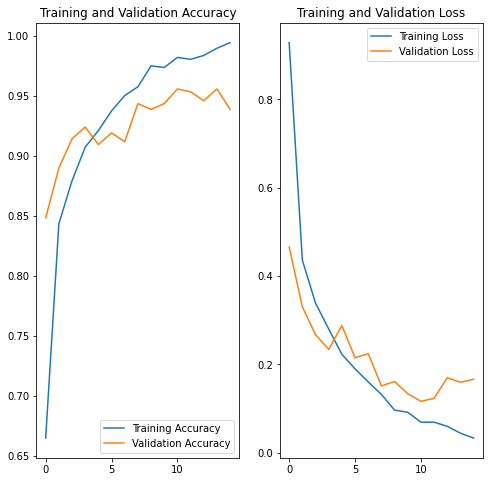

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('kumori.h5')

In [ ]:
model.evaluate(test_dataset,batch_size = BATCH_SIZE)

32/32 [==============================] - 0s 8ms/step - loss: 0.1362 - accuracy: 0.9549


[0.13623416423797607, 0.9549461603164673]

## MLP Train & Test ##

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(train_x.shape, test_x.shape)
print(train_y.shape, test_y.shape)

(4081, 30) (1021, 30)
(4081,) (1021,)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True)

In [ ]:

# train_x = tf.convert_to_tensor(train_x, dtype=tf.float32)
# test_x = tf.convert_to_tensor(test_x, dtype=tf.float32)
# train_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(train_y,  num_classes=6), dtype=tf.float32)
# test_y = tf.convert_to_tensor(tf.keras.utils.to_categorical(test_y,  num_classes=6), dtype=tf.float32)

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

In [ ]:
# BATCH_SIZE = 32
# SHUFFLE_BUFFER_SIZE = 100

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
# for i,j in train_dataset.take(1):
#     print(i.numpy().shape)
#     print(j.numpy().shape)

(30,)
(6,)


In [ ]:
num_classes = 6
num_features = 30
acc_list = {}
f1_list = {}
train_acc_list = {}
fold_no = 1
epochs = 15

for train, test in tqdm(kfold.split(train_x, train_y)):
  model = tf.keras.Sequential([
      tf.keras.Input(shape=train_x.shape[1]),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss= tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

  history = model.fit(
      train_x[train],
      train_y[train],
      epochs=epochs
  )
  train_acc = history.history['accuracy']
  y_pred = model.predict(train_x[test], verbose=0)
  # print(y_pred)
  y_pred_1 = np.argmax(y_pred, axis = 1)
  # print(y_pred_1)
  # print(train_y[test])
  train_y_1 = np.zeros((train_y[test].size, train_y[test].max()+1))
  train_y_1[np.arange(train_y[test].size),train_y[test]] = 1
  # print(train_y_1)
  f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
  acc_metric = tf.keras.metrics.Accuracy()
  acc_metric.update_state(train_y[test], y_pred_1)
  acc = acc_metric.result().numpy()
  # print(acc)
  y_pred_1 = y_pred_1.astype(np.float32)
  f1_metric.update_state(train_y_1, y_pred)
  f1_macro = f1_metric.result().numpy()
  # print(f1_macro)
  print(f"accuracy for fold {fold_no}: {acc}; f1_macro is {f1_macro}")
  acc_list[fold_no] = acc
  train_acc_list[fold_no] = train_acc
  f1_list[fold_no] = f1_macro
  model.save(f"/content/drive/MyDrive/temp_models/{fold_no}.h5")
  fold_no += 1


0it [00:00, ?it/s]

Epoch 1/15
102/102 [==============================] - 3s 3ms/step - loss: 1.5886 - accuracy: 0.3735
Epoch 2/15
102/102 [==============================] - 0s 3ms/step - loss: 1.0597 - accuracy: 0.5928
Epoch 3/15
102/102 [==============================] - 0s 2ms/step - loss: 0.7994 - accuracy: 0.7044
Epoch 4/15
102/102 [==============================] - 0s 3ms/step - loss: 0.6589 - accuracy: 0.7592
Epoch 5/15
102/102 [==============================] - 0s 2ms/step - loss: 0.5734 - accuracy: 0.7763
Epoch 6/15
102/102 [==============================] - 0s 3ms/step - loss: 0.5041 - accuracy: 0.8033
Epoch 7/15
102/102 [==============================] - 0s 2ms/step - loss: 0.4719 - accuracy: 0.8159
Epoch 8/15
102/102 [==============================] - 0s 2ms/step - loss: 0.4328 - accuracy: 0.8324
Epoch 9/15
102/102 [==============================] - 0s 2ms/step - loss: 0.4086 - accuracy: 0.8392
Epoch 10/15
102/102 [==============================] - 0s 2ms/step - loss: 0.3912 - accuracy: 0.8493

In [ ]:
print(acc_list)
print(f1_list)
print(train_acc_list)

{1: 0.92900854, 2: 0.9007353, 3: 0.92401963, 4: 0.9289216, 5: 0.9007353}
{1: 0.8955478, 2: 0.8505114, 3: 0.89477277, 4: 0.8820884, 5: 0.848087}
{1: [0.3734681308269501, 0.5928308963775635, 0.704350471496582, 0.7591911554336548, 0.7763480544090271, 0.8033088445663452, 0.8158701062202454, 0.8324142098426819, 0.8391544222831726, 0.8492646813392639, 0.8498774766921997, 0.8661152124404907, 0.8633578419685364, 0.8700980544090271, 0.873161792755127], 2: [0.396018385887146, 0.6260336637496948, 0.7087289690971375, 0.7562021613121033, 0.7699846625328064, 0.7935681343078613, 0.8064318299293518, 0.8238897323608398, 0.8382848501205444, 0.8447166681289673, 0.8441041111946106, 0.8569678664207458, 0.8633996844291687, 0.870444118976593, 0.8747320175170898], 3: [0.422664612531662, 0.6180704236030579, 0.6918836236000061, 0.7430321574211121, 0.7644716501235962, 0.8009188175201416, 0.8110260367393494, 0.8312404155731201, 0.82756507396698, 0.8462480902671814, 0.8517611026763916, 0.854823887348175, 0.8679938

In [ ]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/temp_models/1.h5')
y_pred = best_model.predict(test_x, verbose=0)
# print(y_pred)
y_pred_1 = np.argmax(y_pred, axis = 1)
# print(y_pred_1)
# print(train_y[test])
train_y_1 = np.zeros((test_y.size, test_y.max()+1))
train_y_1[np.arange(test_y.size),test_y] = 1
# print(train_y_1)
f1_metric = tfa.metrics.F1Score(num_classes= num_classes, average = 'macro', threshold=None)
acc_metric = tf.keras.metrics.Accuracy()
acc_metric.update_state(test_y, y_pred_1)
acc = acc_metric.result().numpy()
# print(acc)
y_pred_1 = y_pred_1.astype(np.float32)
f1_metric.update_state(train_y_1, y_pred)
f1_macro = f1_metric.result().numpy()
print(f"test accuracy is {acc}")
print(f"test f1 macro is {f1_macro}")

test accuracy is 0.9020568132400513
test f1 macro is 0.8555364608764648


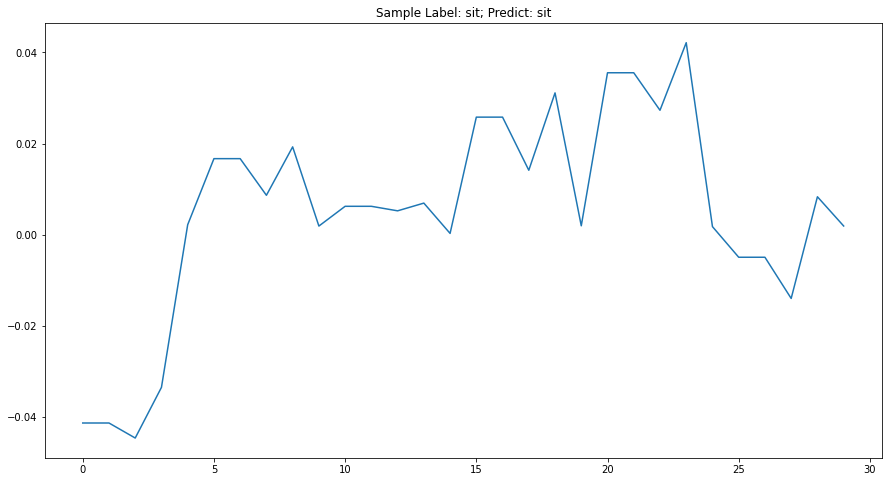

In [ ]:
single_sample = test_x[-1]
sample_label = activity_decodes[test_y[-1]]
prediction = activity_decodes[y_pred[-1]]
plt.figure(figsize=(15, 8))
plt.plot(single_sample)
plt.title(f"Sample Label: {sample_label}; Predict: {prediction}")
plt.show()

# SVM: Feature Extraction, Train and Test #

In [ ]:
#For non NN model, e.x. SVM
#Window size 500, as still
window = 500
feature_n = 6
attributes = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z']
data_all_x_list = []
data_all_y_list = []
for j in folders:
    csv_list = glob(j + '/*')
    label = j.split('/')[-1].split('_')[0]
    for i in csv_list:
        df = pd.read_csv(i, usecols = ['attitude.roll', 'attitude.pitch', 'attitude.yaw','userAcceleration.x','userAcceleration.y','userAcceleration.z'])
        win_count = int(df.shape[0] / (window / 2)) - 1
        data_x = np.zeros((win_count, df.shape[1] * 5))
        data_y = np.zeros(win_count)

        length = len(df)
        for c in range(win_count):
            start_idx = int(c * (window / 2))
            end_idx = start_idx + window
            temp_list = []
            for k in range(feature_n):
              means = df[start_idx:end_idx][attributes[k]].mean()
              stds = df[start_idx:end_idx][attributes[k]].mean()
              mins = df[start_idx:end_idx][attributes[k]].min()
              maxs = df[start_idx:end_idx][attributes[k]].max()
              mads = df[start_idx:end_idx][attributes[k]].mad()
              temp_list.append(means)
              temp_list.append(stds)
              temp_list.append(mins)
              temp_list.append(maxs)
              temp_list.append(mads)
            #temp_list = np.concatenate(temp_list, axis = 0)
            data_x[c] = temp_list
            data_y[c] = activity_codes[label]
#         print(data_x.shape)
#         sys.exit(0)
        data_all_x_list.append(data_x)
        data_all_y_list.append(data_y)
data_all_x = np.concatenate(data_all_x_list,axis=0)
data_all_y = np.concatenate(data_all_y_list,axis=0)
data_all_y = data_all_y.astype(int)
print(data_all_x.shape)
print(data_all_y.shape)

(5102, 30)
(5102,)


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_x,test_x,train_y,test_y = train_test_split(data_all_x,data_all_y,test_size=0.2)
assert(len(train_x) == len(train_y))
assert(len(test_x) == len(test_y))
print(len(train_x), len(test_x))

4081 1021


In [ ]:
scoring = ['f1_macro', 'accuracy']
clf = LinearSVC(C=1, multi_class = 'ovr', random_state=0)
scores = cross_validate(clf, train_x, train_y, scoring=scoring,cv = None, return_estimator = True, return_train_score= True)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [ ]:
print(scores.keys())
print(f"Last epoch validation accuracy: {scores['test_accuracy'][-1]}")
print(f"Last epoch validation f1_macro: {scores['test_f1_macro'][-1]}")
print(f"Last epoch training accuracy: {scores['train_accuracy'][-1]}")
print(f"Last epoch training f1_macro: {scores['train_f1_macro'][-1]}")

dict_keys(['fit_time', 'score_time', 'estimator', 'test_f1_macro', 'train_f1_macro', 'test_accuracy', 'train_accuracy'])
Last epoch validation accuracy: 0.9583333333333334
Last epoch validation f1_macro: 0.9398435584281543
Last epoch training accuracy: 0.9604900459418071
Last epoch training f1_macro: 0.944706504544489


In [ ]:
pred_test_y = scores['estimator'][-1].predict(test_x)
test_accuracy = accuracy_score(test_y, pred_test_y)
test_f1_macro = f1_score(test_y, pred_test_y, average = 'macro')
print(f"test_accuracy is {test_accuracy}")
print(f"test_f1_macro is {test_f1_macro}")

test_accuracy is 0.9431929480901078
test_f1_macro is 0.9171472806610222


In [ ]:
print(f"number of epochs trained : {len(scores['test_accuracy'])}")

number of epochs trained : 5
